# Understanding Causal Impact of Promotion on Emplyee Performance

The data for this exercise is takent from [here](https://studio.azureml.net/Home/ViewWorkspaceCached/90abf1900f5e407cbbc7ccc08102e59a#Workspaces/Experiments/Experiment/90abf1900f5e407cbbc7ccc08102e59a.f-id.4c495001b300451a839cef4ea67474b6/ViewExperiment)

### Introduction

The application of machine learning has gained much visibility in the field of causal analytics in the recent years.  This project utilizes causalml package to understand the impact of promotion on performance of employees.  From theoretical perspectives, good HRM practices leads to employee-centered outcomes such as motivation, job satisfaction, good organizational citizenship and commitment which can boost organizational-centered outcomes such retention, Increase in output and lower law suits leading to sustainable competitive advantage for the organization.  However, not all employees respond to an incentive equally, that is why it is necessary to understand the psychometric characteristics of the employees with the aim of designing optimal HRM systems that will promote employee performance thereby realizing competitive advantage for the organization.

We utilize X-learner algorithm and causalml package to analyze the data, even though we cannot verify the autenticity of our dataset whether it is real or generated, it nevetheless provided a good opportunity to try out the causalml package which I thinkgave some good results.

### Import the necessary Libraries

In [1]:
#Data processing
import pandas as pd
import numpy as np

#Uplift Modelling
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from causalml.inference.meta import BaseXClassifier
from sklearn.linear_model import LinearRegression

#Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

### Data Import and Preprocessing

In [2]:
data = pd.read_csv("Employee_promotion.csv")
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


### Necessary Transformations
* Drop employee_id
* Rename Length_of_service to Experience
* Rename KPIs_met > 80% to Performance
* Rename awards_won? to awards
* Rename is_promoted to Treatment

In [4]:
data = data.drop('employee_id',axis=1)

In [5]:
new_names = {'Length_of_service':'Experience','KPIs_met >80%':'Performance',
             'awards_won':'awards','is_promoted':'Treatment'}

data.rename(columns=new_names,inplace=True)

In [6]:
data.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,Performance,awards_won?,avg_training_score,Treatment
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


### Explore distribution of Treatment and Performance

In [7]:
data['Treatment'].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: Treatment, dtype: float64

In [8]:
data['Performance'].value_counts()

0    35517
1    19291
Name: Performance, dtype: int64

From the above distributions, only 8% of the employee received promotion compared to 91% that did not receive promotion. In this instance, those in category 1 will serve as our Treatment group while we shall draw a sample from category 0 to serve as our Control group.

In [9]:
Treatment_Group = data[data['Treatment']==1]

In [10]:
Control_Group = data[data['Treatment']==0].sample(n=6000,random_state=42)

In [11]:
Treatment_Group['Treatment'].value_counts()

1    4668
Name: Treatment, dtype: int64

In [12]:
Control_Group['Treatment'].value_counts()

0    6000
Name: Treatment, dtype: int64

### Combine Treatment and Control Groups

In [13]:
df = pd.concat([Treatment_Group,Control_Group],axis=0)

In [14]:
df['Treatment'].value_counts()

0    6000
1    4668
Name: Treatment, dtype: int64

In [15]:
df['Performance'].value_counts()

0    5526
1    5142
Name: Performance, dtype: int64

### Perform Initial Analysis of the causal effect

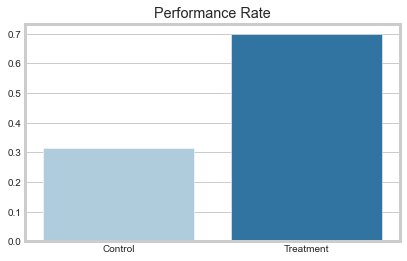

Difference between Control and Treatment 0.38547


In [16]:
sns.set_style("whitegrid")
sns.barplot(x = ['Control', 'Treatment'], y = df.groupby('Treatment')['Performance'].mean().values)
plt.title('Performance Rate')
plt.show()
print(f'Difference between Control and Treatment {np.round(df.groupby("Treatment")["Performance"].mean()[1] - df.groupby("Treatment")["Performance"].mean()[0], 5)}')

Initial analysis suggests that those that got promotion in the dataset have an averge 0f 39% higher performance than those that did not receive promotion. We cannot accept this result for now without probing into the distribution of the treatment and control groups with respect to the provided covariates.

### Exploratory Data analysis
How is the distribution of the dataset with respect to:

* Department
* Region
* Education
* Gender
* Recruitment Channel

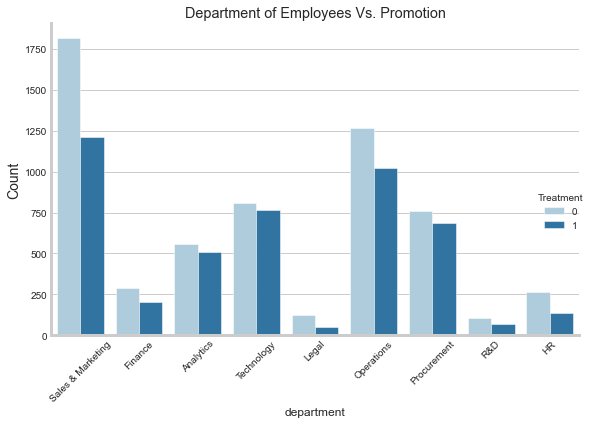

In [17]:
sns.catplot(x="department",kind="count",hue="Treatment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Department of Employees Vs. Promotion");

The distribution of treatment looks almost evenly distrbuted across all the departments, except for Sales and Marketing where the difference looks much larger than the difference in all other departments. However, some departments are less represented in the distribution such as Finance, HR, R&D, Legal and Analytics. This lop-sidedness needs to be corrected for us to accept the result.

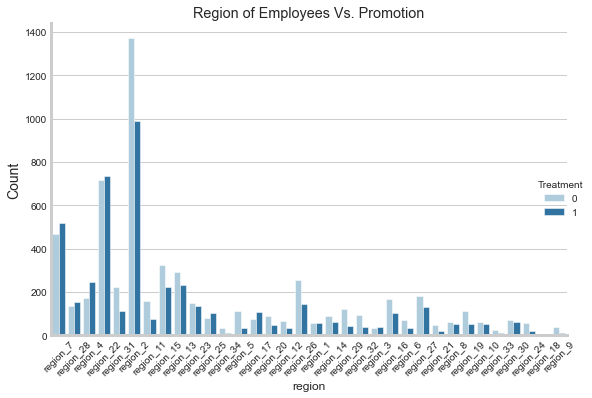

In [18]:
sns.catplot(x="region",kind="count",hue="Treatment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Region of Employees Vs. Promotion");

It is very clear that the sampling across the region is grossly lopsided as the bulk of hte sample came from 3 regions out of 34 regions provided by the data. This will also need to be corrected before our initial result can be accepted.

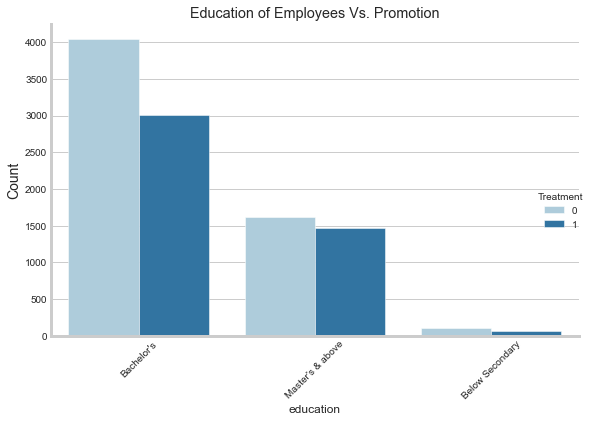

In [19]:
sns.catplot(x="education",kind="count",hue="Treatment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Education of Employees Vs. Promotion");

The sampling distribution is favor of those with Bachelor's degree while those Below Secondary School were grossly under sampled.

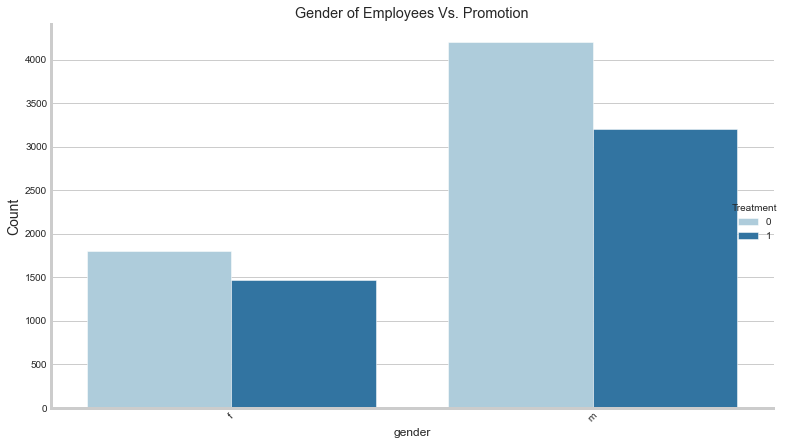

In [20]:
sns.catplot(x="gender",kind="count",hue="Treatment",height=6,aspect=1.7,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Gender of Employees Vs. Promotion");

The proportion of male employees in the sample is almost twice those of the female, hence the distribution is not proportional.

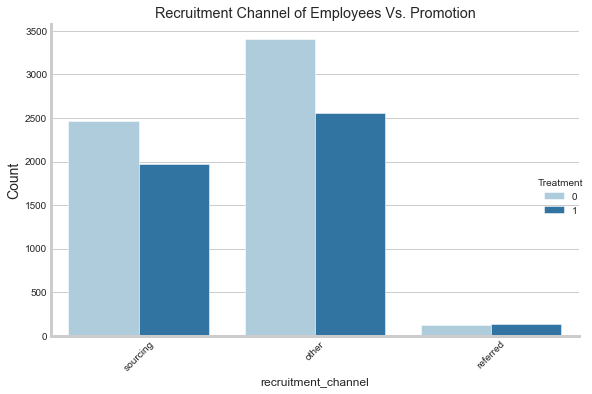

In [21]:
sns.catplot(x="recruitment_channel",kind="count",hue="Treatment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Recruitment Channel of Employees Vs. Promotion");

The recruitment channel also seem a bit disproportional with regards to different channel sources.

On the whole, the sampling distribution of the employees both in the control and treatment groups is somehow lop-sided and this needs to be accounted for before we can accept that promotion indeed leads to higher performance. We shall use causalml package to analyze the data so that the lopsidedness can be corrected.

## CausalML Analysis
### Data Preparation
#### Separate data into:

* treatment
* outcome
* covariates

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10668 entries, 11 to 37443
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            10668 non-null  object 
 1   region                10668 non-null  object 
 2   education             10317 non-null  object 
 3   gender                10668 non-null  object 
 4   recruitment_channel   10668 non-null  object 
 5   no_of_trainings       10668 non-null  int64  
 6   age                   10668 non-null  int64  
 7   previous_year_rating  9888 non-null   float64
 8   length_of_service     10668 non-null  int64  
 9   Performance           10668 non-null  int64  
 10  awards_won?           10668 non-null  int64  
 11  avg_training_score    10668 non-null  int64  
 12  Treatment             10668 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.1+ MB


Remove instances of missing values

In [23]:
df = df.dropna()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9595 entries, 11 to 37443
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            9595 non-null   object 
 1   region                9595 non-null   object 
 2   education             9595 non-null   object 
 3   gender                9595 non-null   object 
 4   recruitment_channel   9595 non-null   object 
 5   no_of_trainings       9595 non-null   int64  
 6   age                   9595 non-null   int64  
 7   previous_year_rating  9595 non-null   float64
 8   length_of_service     9595 non-null   int64  
 9   Performance           9595 non-null   int64  
 10  awards_won?           9595 non-null   int64  
 11  avg_training_score    9595 non-null   int64  
 12  Treatment             9595 non-null   int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.0+ MB


In [25]:
# Get the covariates

X = df.drop(['Treatment','Performance'],axis=1)

In [26]:
X = pd.get_dummies(X,drop_first=True,prefix_sep=("*"))

In [27]:
#Treatment
treatment = df['Treatment']
treatment = np.array(['treatment' if val==1 else 'control' for val in treatment])

# outcome
y = df['Performance']

### Using X-Meta Learner

In [28]:
# Build the propensity model

prop_model = LGBMClassifier(colsample_bytree=0.8, subsample = 0.8, n_estimators=300)
cross_val_score(prop_model, X, treatment, cv=5, scoring='roc_auc').mean()

0.8110402005084325

Propensity score of 0.81 is an evidence of sampling bias

In [29]:
# Fitting the model

prop_model.fit(X,treatment)

LGBMClassifier(colsample_bytree=0.8, n_estimators=300, subsample=0.8)

In [30]:
# Getting the propensity Score

prop_scores = prop_model.predict_proba(X)

### Generating the ATE

In [31]:
learner_x = BaseXClassifier(LGBMClassifier(colsample_bytree=0.8, num_leaves=50, n_estimators=200),
                            control_effect_learner=LinearRegression(),
                            treatment_effect_learner=LinearRegression(), 
                            control_name='control')

In [32]:
#Getting the average treatment effect with upper and lower bounds
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p = prop_scores[:, 1])

In [33]:
ate_x, ate_x_lb, ate_x_ub

(array([0.42223023]), array([0.41222929]), array([0.43223118]))

### Generate the ITE

In [35]:
#Getting the average treatment effect with upper and lower bounds
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p = prop_scores[:, 1])

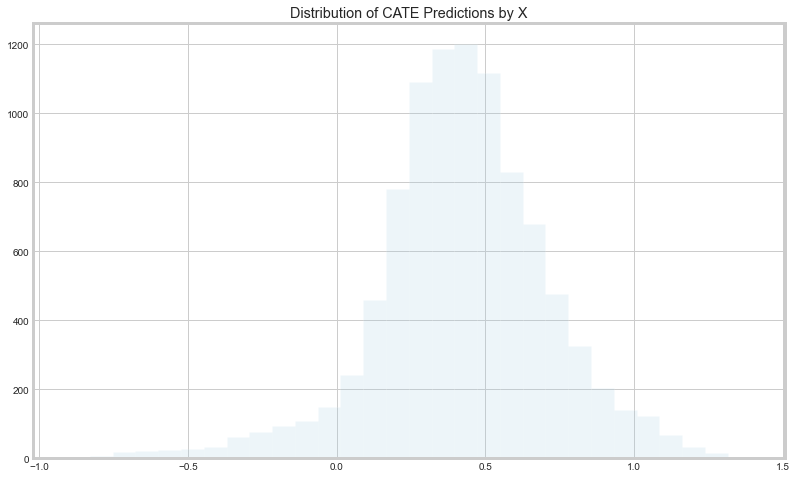

In [37]:
alpha = 0.2
bins = 30
plt.figure(figsize=(12,8))
plt.hist(cate_x,alpha=alpha,bins=bins,label='X-Learner')
plt.title('Distribution of CATE Predictions by X');

In [38]:
X['ite'] = cate_x

In [39]:
X.head()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,department*Finance,department*HR,department*Legal,department*Operations,...,region*region_6,region*region_7,region*region_8,region*region_9,education*Below Secondary,education*Master's & above,gender*m,recruitment_channel*referred,recruitment_channel*sourcing,ite
11,1,35,5.0,3,0,50,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0.404515
39,1,33,5.0,6,0,51,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0.405538
60,1,50,4.0,17,0,47,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.738824
69,1,30,3.0,7,0,84,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.593513
71,1,34,5.0,7,0,78,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.234441


### Segementation of employees according to ITE effects.

In order to segment the employees into groups, we adopt the [grabngo](https://colab.research.google.com/drive/12oz8O04Gz1B8RC9w_RJWCDCysHiNieTo?usp=sharing) method.

* Persuadables--Those who put in super peformance at work through promotion incentive
* Sleeping dogs--Those who put in super performance without promotion and do not put on super performance with promotion
* No Impact--Those who put in their super performance with or without promotion



In [40]:
# Segmentation function

def segmentation(x):
    if x < -0.5:
        return 'sleeping-dog'
    elif x > 0.5:
        return 'persuadables'
    else:
        return 'no_impact'

In [41]:
X['ite_segment'] = X['ite'].apply(segmentation)

In [42]:
X.head()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,department*Finance,department*HR,department*Legal,department*Operations,...,region*region_7,region*region_8,region*region_9,education*Below Secondary,education*Master's & above,gender*m,recruitment_channel*referred,recruitment_channel*sourcing,ite,ite_segment
11,1,35,5.0,3,0,50,0,0,0,0,...,1,0,0,0,0,0,0,1,0.404515,no_impact
39,1,33,5.0,6,0,51,0,0,0,0,...,0,0,0,0,0,1,0,1,0.405538,no_impact
60,1,50,4.0,17,0,47,0,0,0,0,...,0,0,0,0,1,1,0,0,0.738824,persuadables
69,1,30,3.0,7,0,84,0,0,0,0,...,0,0,0,0,0,1,0,0,0.593513,persuadables
71,1,34,5.0,7,0,78,0,0,0,0,...,0,0,0,0,1,1,0,0,0.234441,no_impact


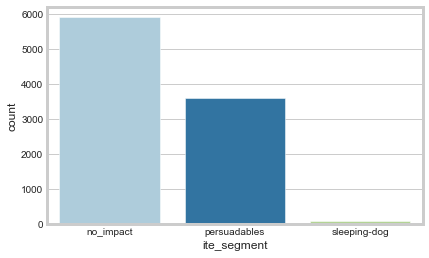

In [44]:
sns.countplot(x = X['ite_segment']);

In [48]:
df['ite'] = cate_x

In [49]:
df['ite_segment'] = df['ite'].apply(segmentation)

In [50]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,Performance,awards_won?,avg_training_score,Treatment,ite,ite_segment
11,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,0.404515,no_impact
39,Sales & Marketing,region_28,Bachelor's,m,sourcing,1,33,5.0,6,1,0,51,1,0.405538,no_impact
60,Sales & Marketing,region_4,Master's & above,m,other,1,50,4.0,17,1,0,47,1,0.738824,persuadables
69,Analytics,region_31,Bachelor's,m,other,1,30,3.0,7,1,0,84,1,0.593513,persuadables
71,Technology,region_22,Master's & above,m,other,1,34,5.0,7,1,0,78,1,0.234441,no_impact


### Promotion vs. Department, Education and Gender

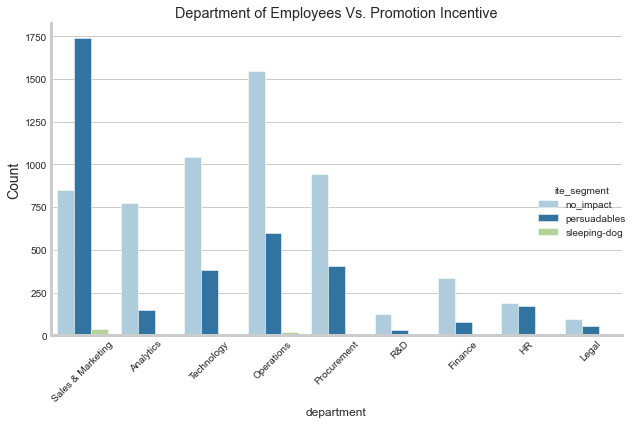

In [51]:
sns.catplot(x="department",kind="count",hue="ite_segment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Department of Employees Vs. Promotion Incentive");

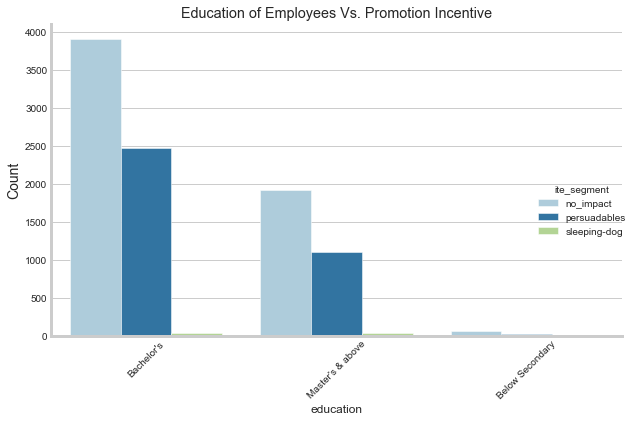

In [52]:
sns.catplot(x="education",kind="count",hue="ite_segment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Education of Employees Vs. Promotion Incentive");

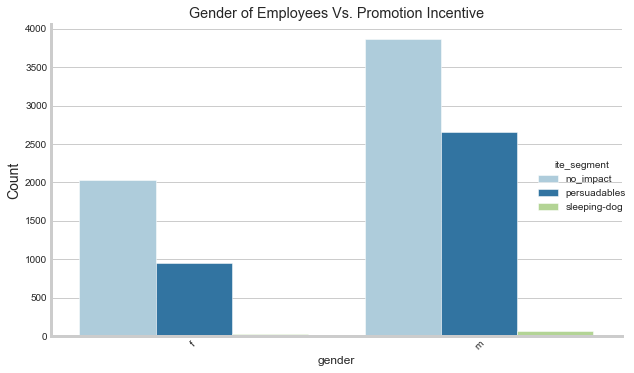

In [53]:
sns.catplot(x="gender",kind="count",hue="ite_segment",height=5,aspect=1.5,data=df)
plt.ylabel("Count",size=14)
plt.tight_layout()
plt.xticks(rotation= 45)
plt.title("Gender of Employees Vs. Promotion Incentive");

### Conclusions

* Promotion incentive has a positive impact on performance of the employees.  Those who received promotion were 45% more productive than those without promotion.
* There were about 3000 employees that were motivated by promotion while promotion did not have any impact on about 6000 employees.
* Those working in Sales and Marketing units were most responsive to promotion compared to other departments
* Male employees also seem to respond more to promotion than their female counterparts.

In using promotion as an incentive to boost productivity, the company should target employees in sales and marketing as well as male employees as much as possible.

### Credits

* Explainable S learner uplift model using python package causalml by Amy--Grab N GoInfo
* CausalML:  Analyzing AB Test by Antons Ruberts